# Trailer: Bio-image Analysis with Python
In this collection of notebooks we will dive into image analysis, machine learning and bio-statistics with Python. This notebook serves as a trailer of what we will be doing.

## Working with image data

In [1]:
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from cellpose import models, io
from skimage import measure
import pandas as pd
import apoc

2022-01-23 11:51:29,582 [INFO] WRITING LOG OUTPUT TO /Users/haase/.cellpose/run.log


In [2]:
# open an image file
image = imread("../../data/blobs.tif")
print("Image size", image.shape)

Image size (254, 256)


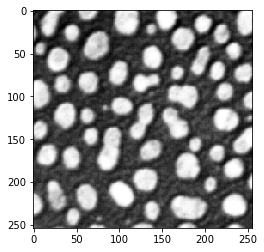

In [3]:
# visualizing an image
cle.imshow(image, color_map="Greys_r")

## Image segmentation

2022-01-23 11:51:29,781 [INFO] >>>> using CPU
2022-01-23 11:51:29,822 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2022-01-23 11:51:37,384 [WARNING] WARNING: not interp
2022-01-23 11:51:37,589 [INFO] estimated cell diameter(s) in 7.77 sec
2022-01-23 11:51:37,589 [INFO] >>> diameter(s) = 
2022-01-23 11:51:37,589 [INFO] [ 19.25 ]
2022-01-23 11:51:37,590 [INFO] ~~~ FINDING MASKS ~~~
2022-01-23 11:51:51,327 [INFO] >>>> TOTAL TIME 21.51 sec


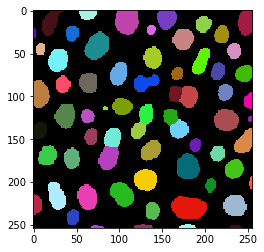

In [4]:
# load cellpose model
model = models.Cellpose(gpu=False, model_type='nuclei')

# apply model
channels = [0,0] # This means we are processing single channel greyscale images.
label_image, flows, styles, diams = model.eval(image, diameter=None, channels=channels)

# show result
cle.imshow(label_image, labels=True)

## Measurements and feature extraction

In [5]:
statistics = measure.regionprops_table(label_image, intensity_image=image,
                                  properties=('area', 'mean_intensity'))

## Working with tables

In [6]:
# show table
dataframe = pd.DataFrame(statistics)
dataframe

,area,mean_intensity
0,440,188.654545
1,201,173.572139
2,663,204.404223
3,433,216.554273
4,455,214.839560
...,...,...
61,217,182.488479
62,81,185.086420
63,75,185.600000
64,48,193.166667


## Descriptive statistics

In [7]:
print("Mean blob area is", np.mean(dataframe['area']), "pixels")

Mean blob area is 336.3787878787879 pixels


## Spatial statistics

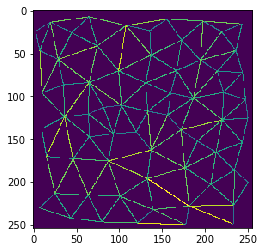

In [8]:
voronoi_labels = cle.extend_labeling_via_voronoi(label_image)
distance_mesh = cle.draw_distance_mesh_between_touching_labels(voronoi_labels)

cle.imshow(distance_mesh)

## Visualization

In [9]:
area = [0] + dataframe['area'].tolist()
print(area)

[0, 440, 201, 663, 433, 455, 281, 233, 94, 288, 44, 496, 677, 125, 239, 433, 423, 504, 416, 271, 343, 167, 422, 420, 271, 517, 287, 231, 423, 161, 361, 540, 337, 17, 212, 274, 597, 33, 354, 273, 261, 366, 232, 452, 166, 420, 411, 250, 502, 373, 651, 375, 558, 63, 168, 509, 585, 536, 213, 543, 874, 281, 217, 81, 75, 48, 35]


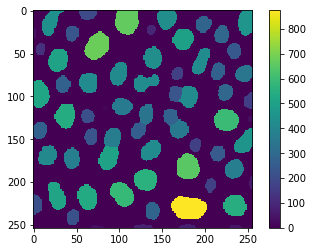

In [10]:
parametric_image = cle.replace_intensities(label_image, area)

cle.imshow(parametric_image, colorbar=True)

## Classification

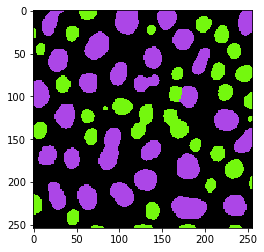

In [11]:
object_classifier = apoc.ObjectClassifier('../../data/blobs_classifier.cl')
classification_image = object_classifier.predict(label_image, image)

cle.imshow(classification_image, labels=True)